the ssl_mat and final.pt (pretrained model) in model folder
output.p in data_mat folder (for jupyter in Lab)


In [1]:

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import random
import h5py

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import os
random.seed(0) # for validation

import time # measure training time

In [3]:
data_path = 'part_1.mat'

In [5]:
M = scipy.io.loadmat(data_path)['p'][0]

In [7]:
M.shape

(1000,)

In [9]:
M = M[:]
n_subjects = M.shape[0]
n_subjects

1000

In [11]:
import numpy as np

def split_signals(subjects, segment_length=1000):
    segmented_subjects = []
    for subject in subjects:
        ppg_signal = subject[0]
        abp_signal = subject[1]
        ecg_signal = subject[2]

        # Find the number of complete segments of length 'segment_length'
        num_segments = ppg_signal.shape[0] // segment_length

        for i in range(num_segments):
            start_idx = i * segment_length
            end_idx = start_idx + segment_length
            segmented_subjects.append([
                ppg_signal[start_idx:end_idx],
                abp_signal[start_idx:end_idx],
                ecg_signal[start_idx:end_idx]
            ])

    return np.array(segmented_subjects)

# Example usage with your dataset M
segmented_M = split_signals(M)
print(f"Segmented dataset shape: segmented_M.shape = {segmented_M.shape}")


Segmented dataset shape: segmented_M.shape = (32061, 3, 1000)


In [13]:
!mkdir data_mat

In [15]:
import numpy as np
import os
from tqdm import tqdm
import pickle
from sklearn.model_selection import KFold

# Assuming segmented_M is already loaded and has shape (32061, 3, 1000)

def fold_data():
    """
        Folds the data into splits and saves them
        to perform 10-fold cross-validation
    """

    length = 1000  # length of the signals
    total_samples = 25000
    test_samples = 32061 - total_samples

    X = segmented_M[:total_samples, 0, :]  # PPG signals
    Y = segmented_M[:total_samples, 1, :]  # ABP signals

    X_test = segmented_M[total_samples:, 0, :]  # Test PPG signals
    Y_test = segmented_M[total_samples:, 1, :]  # Test ABP signals

    X = X[..., np.newaxis]
    Y = Y[..., np.newaxis]

    X_test = X_test[..., np.newaxis]
    Y_test = Y_test[..., np.newaxis]

    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Y_test shape: {Y_test.shape}")

    kf = KFold(n_splits=10)

    for fold_id, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]

        # Normalization based on training data statistics
        min_ppg, max_ppg = X_train.min(), X_train.max()
        min_abp, max_abp = Y_train.min(), Y_train.max()

        X_train = (X_train - min_ppg) / (max_ppg - min_ppg)
        Y_train = (Y_train - min_abp) / (max_abp - min_abp)

        X_val = (X_val - min_ppg) / (max_ppg - min_ppg)
        Y_val = (Y_val - min_abp) / (max_abp - min_abp)

        # Save training and validation splits
        pickle.dump({'X_train': X_train, 'Y_train': Y_train}, open(os.path.join('data_mat', f'train{fold_id}.p'), 'wb'))
        pickle.dump({'X_val': X_val, 'Y_val': Y_val}, open(os.path.join('data_mat', f'val{fold_id}.p'), 'wb'))

        # Save normalization metadata
        pickle.dump({'max_ppg': max_ppg, 'min_ppg': min_ppg, 'max_abp': max_abp, 'min_abp': min_abp}, open(os.path.join('data_mat', f'meta{fold_id}.p'), 'wb'))

    # Normalization based on training data statistics for test set
    X_test = (X_test - min_ppg) / (max_ppg - min_ppg)
    Y_test = (Y_test - min_abp) / (max_abp - min_abp)

    # Save test split
    pickle.dump({'X_test': X_test, 'Y_test': Y_test}, open(os.path.join('data_mat', 'test.p'), 'wb'))

def main():
    fold_data()  # splits the data for 10-fold cross-validation

if __name__ == '__main__':
    main()

X shape: (25000, 1000, 1)
Y shape: (25000, 1000, 1)
X_test shape: (7061, 1000, 1)
Y_test shape: (7061, 1000, 1)


In [19]:
file_path = 'data_mat/meta0.p'
with open(file_path, 'rb') as f:
        data = pickle.load(f)

print(data.keys())

print(data['max_ppg'])
print(data['min_ppg'])
print(data['max_abp'])
print(data['min_abp'])


dict_keys(['max_ppg', 'min_ppg', 'max_abp', 'min_abp'])
4.001955034213099
0.0
199.90934525391145
50.05529136399692


In [31]:
import pickle
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class BPdatasetv1(Dataset):
    def __init__(self, fold_num, train=False, val=False):
        if train:
            dt = pickle.load(open(os.path.join('data_mat', f'train{fold_num}.p'), 'rb'))
            self.input = np.swapaxes(dt['X_train'], 1, 2).astype('float32')
            self.output = np.swapaxes(dt['X_train'], 1, 2).astype('float32')
        elif val:
            dt = pickle.load(open(os.path.join('data_mat', f'val{fold_num}.p'), 'rb'))
            self.input = np.swapaxes(dt['X_val'], 1, 2).astype('float32')
            self.output = np.swapaxes(dt['X_val'], 1, 2).astype('float32')

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        inp = self.input[idx]
        out = self.output[idx]
        return inp, out

class BPdatasetv2(Dataset):
    def __init__(self, fold_num, train=False, val=False, test=False):
        if train:
            dt = pickle.load(open(os.path.join('data_mat', f'train{fold_num}.p'), 'rb'))
            self.input = np.swapaxes(dt['X_train'], 1, 2).astype('float32')
            self.output = np.swapaxes(dt['Y_train'], 1, 2).astype('float32')
        elif val:
            dt = pickle.load(open(os.path.join('data_mat', f'val{fold_num}.p'), 'rb'))
            self.input = np.swapaxes(dt['X_val'], 1, 2).astype('float32')
            self.output = np.swapaxes(dt['Y_val'], 1, 2).astype('float32')
        elif test:
            dt = pickle.load(open(os.path.join('data_mat', 'test.p'), 'rb'))
            self.input = np.swapaxes(dt['X_test'], 1, 2).astype('float32')
            self.output = np.swapaxes(dt['Y_test'], 1, 2).astype('float32')

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        inp = self.input[idx]
        out = self.output[idx]
        return inp, out


In [33]:
import torch
import torch.nn as nn


class IncBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size = 15, stride = 1, padding = 7):
        super(IncBlock,self).__init__()

        self.conv1x1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias = False)

        self.conv1 = nn.Sequential(nn.Conv1d(in_channels, out_channels//4, kernel_size = size, stride = stride, padding = padding ),
                                   nn.BatchNorm1d(out_channels//4))

        self.conv2 = nn.Sequential(nn.Conv1d(in_channels, out_channels//4, kernel_size = 1, bias = False),
                                   nn.BatchNorm1d(out_channels//4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv1d(out_channels//4, out_channels//4, kernel_size = size +2 , stride = stride, padding = padding + 1),
                                   nn.BatchNorm1d(out_channels//4))

        self.conv3 = nn.Sequential(nn.Conv1d(in_channels, out_channels//4, kernel_size = 1, bias = False),
                                   nn.BatchNorm1d(out_channels//4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv1d(out_channels//4, out_channels//4, kernel_size = size + 4 , stride = stride, padding = padding + 2),
                                   nn.BatchNorm1d(out_channels//4))


        self.conv4 = nn.Sequential(nn.Conv1d(in_channels, out_channels//4, kernel_size = 1, bias = False),
                                   nn.BatchNorm1d(out_channels//4),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv1d(out_channels//4, out_channels//4, kernel_size = size + 6 , stride = stride, padding = padding + 3),
                                   nn.BatchNorm1d(out_channels//4))
        self.relu = nn.ReLU()
    def forward(self,x):
        res = self.conv1x1(x)
#         print (res.size())


        c1 = self.conv1(x)
#         print (c1.size())

        c2 = self.conv2(x)
#         print (c2.size())

        c3 = self.conv3(x)
#         print (c3.size())

        c4 = self.conv4(x)
#         print (c4.size())

        concat = torch.cat((c1,c2,c3,c4),dim = 1)

        concat+=res
#         print (concat.shape)
        return self.relu(concat)




class InterAxialBlock(nn.Module):
        #3
  def __init__(self,in_channels = 1, out_channels = 1):

    super(InterAxialBlock, self).__init__()

    self.conv1 = nn.Conv1d(in_channels,8,3)
    self.bn1 = nn.BatchNorm1d(8)

    self.conv2 = nn.Conv1d(8,16,3)
    self.bn2 =nn.BatchNorm1d(16)

    self.conv3 = nn.Conv2d(1,1,(3,3), 2)
    self.bn3 = nn.BatchNorm2d(1)

    self.conv4 = nn.Conv2d(1, 1, (3,15), padding = (0,7))
    self.bn4 = nn.BatchNorm2d(1)

    self.conv5 = nn.Conv1d(1,out_channels,3, padding = 1)
    self.bn5 = nn.BatchNorm1d(out_channels)
    self.relu1 = nn.LeakyReLU(0.2)


    self.mp1 = nn.MaxPool1d(2)
    self.mp2 = nn.MaxPool2d((2,2))




  def forward(self, x):

#     print("in Inter",x.shape)
    x = self.relu1(self.bn1(self.conv1(x)))

    x = self.relu1(self.bn2(self.conv2(x)))
#3d -> 4d
    x = x.view(x.shape[0],1,x.shape[1],x.shape[2])

    x = self.relu1(self.bn3(self.conv3(x)))

    x = self.mp2(x)


    x = self.relu1(self.bn4(self.conv4(x)))


    x = torch.squeeze(x, dim = 1)
    x = self.relu1(self.bn5(self.conv5(x)))


    return x

class Unet(nn.Module):
    def __init__(self, shape):
        super(Unet, self).__init__()
        #1
        in_channels = 1

        self.inter = nn.Sequential(InterAxialBlock())

        self.en1 = nn.Sequential(nn.Conv1d(in_channels, 32, 3, padding = 1),
                                nn.BatchNorm1d(32),
                                nn.LeakyReLU(0.2),
                                nn.Conv1d(32, 32, 5, stride = 2, padding = 2),
                                IncBlock(32,32))

        self.en2 = nn.Sequential(nn.Conv1d(32, 64, 3, padding = 1),
                                nn.BatchNorm1d(64),
                                nn.LeakyReLU(0.2),
                                 nn.Conv1d(64, 64, 5, stride = 2, padding = 2),
                                IncBlock(64,64))


        self.en3 = nn.Sequential(nn.Conv1d(64,128, 3, padding = 1),
                                 nn.BatchNorm1d(128),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv1d(128, 128, 3, stride = 2, padding = 1),
                                IncBlock(128,128))

        self.en4 = nn.Sequential(nn.Conv1d(128,256, 3,padding = 1),
                                 nn.BatchNorm1d(256),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv1d(256, 256, 5, stride = 2, padding = 1),
                                IncBlock(256,256))


        self.en5 = nn.Sequential(nn.Conv1d(256,512, 3, padding = 1),
                                 nn.BatchNorm1d(512),
                                 nn.LeakyReLU(0.2),
                                 IncBlock(512,512))


        self.de1 = nn.Sequential(nn.ConvTranspose1d(512,256,1),
                               nn.BatchNorm1d(256),
                               nn.LeakyReLU(0.2),
                                IncBlock(256,256))

        self.de2 =  nn.Sequential(nn.Conv1d(512,256,3, padding = 1),
                               nn.BatchNorm1d(256),
                               nn.LeakyReLU(0.2),
                                  nn.ConvTranspose1d(256,128,3, stride = 2),
                                IncBlock(128,128))

        self.de3 =  nn.Sequential(nn.Conv1d(256,128,3, stride = 1, padding = 1),
                               nn.BatchNorm1d(128),
                               nn.LeakyReLU(0.2),
                                nn.ConvTranspose1d(128,64,3, stride = 2),
                                IncBlock(64,64))

        self.de4 =  nn.Sequential(nn.Conv1d(128,64,3, stride = 1, padding = 1),
                               nn.BatchNorm1d(64),
                               nn.LeakyReLU(0.2),
                                nn.ConvTranspose1d(64,32,3, stride = 2),
                                IncBlock(32,32))

        self.de5 = nn.Sequential(nn.Conv1d(64,32,3, stride = 1, padding = 1),
                               nn.BatchNorm1d(32),
                               nn.LeakyReLU(0.2),
                                nn.ConvTranspose1d(32,16,3, stride = 2),

                                IncBlock(16,16))

        self.de6 = nn.Sequential(nn.ConvTranspose1d(16,8,2,stride =2),
                                nn.BatchNorm1d(8),
                                nn.LeakyReLU(0.2))

        self.de7 = nn.Sequential(nn.ConvTranspose1d(8,4,2,stride =2),
                                nn.BatchNorm1d(4),
                                nn.LeakyReLU(0.2))

        self.de8 = nn.Sequential(nn.ConvTranspose1d(4,2,1,stride =1),
                                nn.BatchNorm1d(2),
                                nn.LeakyReLU(0.2))

        self.de9 = nn.Sequential(nn.ConvTranspose1d(2,1,1,stride =1),
                                nn.BatchNorm1d(1),
                                nn.LeakyReLU(0.2),
                                 nn.ConstantPad1d((3, 3), 0))


    def forward(self,x):

        #print("Before inter ",x.shape)
        x = self.inter(x)
        #print(" After Inter",x.shape)

        x = nn.ConstantPad1d((1,1),0)(x)
        #print ("After ConstantPad1d",x.shape)
        e1 = self.en1(x)
        #print ("After e1 ",e1.shape)

        e2 = self.en2(e1)
        #print ("After e2 ",e2.shape)

        e3 = self.en3(e2)
        #print ("After e3 ",e3.shape)

        e4 = self.en4(e3)
        #print ("After e4  ",e4.shape)

        e5 = self.en5(e4)
        #print ("After e5 ",e5.shape)
        #print ("-----------------------------------------------------------------------------")
        d1 = self.de1(e5)
        #print ("After d1", d1.shape)

        #print("Before cat d1 e4 {} {}".format(d1.shape,e4.shape))
        cat = torch.cat([d1,e4],1)
        #print("After cat d1 e4 {}".format(cat.shape))

        d2 = self.de2(cat)
        #print ("After d2 ",d2.shape)

        #print ("Before cat d2 e3 {} {}  ".format(d2.shape,e3.shape))
        cat = torch.cat([d2,e3[:,:,:-1]],1)
        #print("After cat d2 e3 {}".format(cat.shape))



        d3 = self.de3(cat)

        #print ("After d3 ",d3.shape)
        #print ("Before cat d3 e2 {} {}  ".format(d3.shape,e2.shape))
        #print("-1 being done on d3")
        cat = torch.cat([d3,e2[:,:,:]],1) #MADE A CHANGE HERE, ADDED -1
        #print("After cat d3 e2 {}".format(cat.shape))

        d4 = self.de4(cat)
        #print ("After d4 ",d4.shape)

        #print ("Before cat d4 e1 {} {}  ".format(d4.shape,e1.shape))
        cat = torch.cat([d4[:,:,:-2],e1],1) #MADE A CHANGE HERE, ([d4[:,:,:-2],e1],1) this is the original one

        #print("After cat d4 e1 {}".format(cat.shape))
        #print("here")
        d5 = self.de5(cat)[:,:,:-2]
        #print ("After d5 ", d5.shape)

        d6 = self.de6(d5)[:,:,:-1]

        #print(d6.shape)

        d7 = self.de7(d6)
        #print("d7 ", d7.shape)
        d8 = self.de8(d7)
        #print(d8.shape)
        d9 = self.de9(d8)
        #print(d9.shape)
        return d9

In [35]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0.1):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True
        else:
            self.counter = 0  # Reset counter if criteria not met
            self.early_stop = False

        return self.early_stop


In [37]:
!mkdir model

A subdirectory or file model already exists.


In [39]:
train_loader = DataLoader(BPdatasetv1(0, train=True), batch_size=32, shuffle=True)

In [41]:
import os
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import time

bs = 256
length = 1000
epochs = 50
folds = 10

model = Unet((bs, 1, length)).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200], gamma=0.1)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(tolerance=5)

best_loss = 1000


start = time.time()
for epoch in range(epochs):
    model.train()
    print('Epoch {}/{}'.format(epoch + 1, epochs))

    running_loss = 0.0
    running_loss_v = 0.0

    for fold in range(1, folds + 1):
        train_loader = DataLoader(BPdatasetv1(fold-1, train=True), batch_size=bs, shuffle=True)
        val_loader = DataLoader(BPdatasetv1(fold-1, val=True), batch_size=bs, shuffle=False)

        for idx, (inputs, output) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs = inputs.cuda()
            output = output.cuda()

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                pred = model(inputs)
                # Adjust output to match pred's shape if necessary
                if pred.shape != output.shape:
                    output = output[:, :, :pred.shape[2]]  # Trim output along dimension 2
                loss = criterion(pred, output)


            scaler.scale(loss).backward()
            running_loss += loss.item() * inputs.size(0)
            scaler.step(optimizer)
            scaler.update()

        scheduler.step()

        # VALIDATION
        model.eval()
        with torch.no_grad():
            for idx, (inputs_v, labels_v) in tqdm(enumerate(val_loader), total=len(val_loader)):
                inputs_v = inputs_v.cuda()
                labels_v = labels_v.cuda()
                outputs_v = model(inputs_v).cuda()
                loss_v = criterion(outputs_v, labels_v)
                running_loss_v += loss_v.item() * inputs_v.size(0)

    avg_train_loss = running_loss / (len(train_loader.dataset) * folds)
    avg_val_loss = running_loss_v / (len(val_loader.dataset) * folds)

    path = 'model/ssl_mat.pt'

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_dev_loss': best_loss,
            'exp_dir': 'model'
        }, f=path)
    print('Loss: {:.4f}   Val_loss: {:.4f}'.format(avg_train_loss, avg_val_loss))

    if early_stopper(avg_train_loss, avg_val_loss):
      print("Early stopping")
      break

end = time.time()
training_duration = end - start

hours, rem = divmod(training_duration, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Training duration: {training_duration} seconds")
print(f"Training duration: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

Epoch 1/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.61it/s]


Loss: 0.0634   Val_loss: 0.0386
Epoch 2/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.96it/s]


Loss: 0.0205   Val_loss: 0.0550
Epoch 3/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.02it/s]


Loss: 0.0137   Val_loss: 0.0467
Epoch 4/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.57it/s]


Loss: 0.0116   Val_loss: 0.0477
Epoch 5/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.36it/s]


Loss: 0.0103   Val_loss: 0.0573
Epoch 6/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.51it/s]


Loss: 0.0094   Val_loss: 0.0413
Epoch 7/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.78it/s]


Loss: 0.0088   Val_loss: 0.0456
Epoch 8/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.00it/s]


Loss: 0.0087   Val_loss: 0.2749
Epoch 9/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.38it/s]


Loss: 0.0102   Val_loss: 0.0286
Epoch 10/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.06it/s]


Loss: 0.0079   Val_loss: 0.0436
Epoch 11/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.70it/s]


Loss: 0.0081   Val_loss: 0.0329
Epoch 12/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.76it/s]


Loss: 0.0077   Val_loss: 0.0380
Epoch 13/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.42it/s]


Loss: 0.0075   Val_loss: 0.0389
Epoch 14/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.63it/s]


Loss: 0.0075   Val_loss: 0.0457
Epoch 15/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.51it/s]


Loss: 0.0073   Val_loss: 0.0473
Epoch 16/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 72.96it/s]


Loss: 0.0071   Val_loss: 0.0444
Epoch 17/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.25it/s]


Loss: 0.0073   Val_loss: 0.0495
Epoch 18/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.37it/s]


Loss: 0.0071   Val_loss: 0.0479
Epoch 19/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.75it/s]


Loss: 0.0069   Val_loss: 0.0455
Epoch 20/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.48it/s]


Loss: 0.0068   Val_loss: 0.0466
Epoch 21/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.87it/s]


Loss: 0.0076   Val_loss: 0.0348
Epoch 22/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.75it/s]


Loss: 0.0075   Val_loss: 0.0345
Epoch 23/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.17it/s]


Loss: 0.0073   Val_loss: 0.0338
Epoch 24/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.87it/s]


Loss: 0.0073   Val_loss: 0.0336
Epoch 25/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.00it/s]


Loss: 0.0074   Val_loss: 0.0333
Epoch 26/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.63it/s]


Loss: 0.0073   Val_loss: 0.0339
Epoch 27/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.98it/s]


Loss: 0.0073   Val_loss: 0.0341
Epoch 28/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.52it/s]


Loss: 0.0074   Val_loss: 0.0354
Epoch 29/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.09it/s]


Loss: 0.0073   Val_loss: 0.0343
Epoch 30/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.98it/s]


Loss: 0.0072   Val_loss: 0.0331
Epoch 31/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.29it/s]


Loss: 0.0073   Val_loss: 0.0347
Epoch 32/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.95it/s]


Loss: 0.0072   Val_loss: 0.0342
Epoch 33/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.67it/s]


Loss: 0.0073   Val_loss: 0.0354
Epoch 34/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.22it/s]


Loss: 0.0072   Val_loss: 0.0343
Epoch 35/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.11it/s]


Loss: 0.0072   Val_loss: 0.0346
Epoch 36/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.88it/s]


Loss: 0.0074   Val_loss: 0.0363
Epoch 37/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.91it/s]


Loss: 0.0073   Val_loss: 0.0346
Epoch 38/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.21it/s]


Loss: 0.0074   Val_loss: 0.0372
Epoch 39/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.11it/s]


Loss: 0.0075   Val_loss: 0.0367
Epoch 40/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.26it/s]


Loss: 0.0074   Val_loss: 0.0356
Epoch 41/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.00it/s]


Loss: 0.0076   Val_loss: 0.0383
Epoch 42/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.22it/s]


Loss: 0.0075   Val_loss: 0.0349
Epoch 43/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.85it/s]


Loss: 0.0074   Val_loss: 0.0386
Epoch 44/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.26it/s]


Loss: 0.0074   Val_loss: 0.0391
Epoch 45/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.93it/s]


Loss: 0.0074   Val_loss: 0.0369
Epoch 46/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.15it/s]


Loss: 0.0073   Val_loss: 0.0379
Epoch 47/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.70it/s]


Loss: 0.0073   Val_loss: 0.0358
Epoch 48/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.26it/s]


Loss: 0.0073   Val_loss: 0.0381
Epoch 49/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 60.84it/s]


Loss: 0.0074   Val_loss: 0.0373
Epoch 50/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.20it/s]


Loss: 0.0073   Val_loss: 0.0375


In [43]:
import os
import re
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import time

bs = 256
length = 1000
epochs = 50
folds = 10

train_losses = []
val_losses = []


# Initialize the model and load pretrained weights if available
model = Unet((bs, 1, length)).cuda()
path = 'model/ssl_mat.pt'  # Path to your pretrained model checkpoint
checkpoint = torch.load(path)
pretrained_dict = {k: v for k, v in checkpoint['model'].items() if re.search('^e|^i', k)}

model_dict = model.state_dict()
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.SmoothL1Loss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200], gamma=0.1)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(tolerance=5)

best_loss = 1000


start_time = time.time()
for epoch in range(epochs):
    model.train()
    print('Epoch {}/{}'.format(epoch + 1, epochs))

    running_loss = 0.0
    running_loss_v = 0.0

    for fold in range(1, folds + 1):
        train_loader = DataLoader(BPdatasetv2(fold-1, train=True), batch_size=bs, shuffle=True)
        val_loader = DataLoader(BPdatasetv2(fold-1, val=True), batch_size=bs, shuffle=False)

        for idx, (inputs, output) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs = inputs.cuda()
            output = output.cuda()

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                pred = model(inputs)
                loss = criterion(pred, output)

            scaler.scale(loss).backward()
            running_loss += loss.item() * inputs.size(0)
            scaler.step(optimizer)
            scaler.update()

        scheduler.step()

        # VALIDATION
        model.eval()
        with torch.no_grad():
            for idx, (inputs_v, labels_v) in tqdm(enumerate(val_loader), total=len(val_loader)):
                inputs_v = inputs_v.cuda()
                labels_v = labels_v.cuda()
                outputs_v = model(inputs_v).cuda()
                loss_v = criterion(outputs_v, labels_v)
                running_loss_v += loss_v.item() * inputs_v.size(0)

    avg_train_loss = running_loss / (len(train_loader.dataset) * folds)
    avg_val_loss = running_loss_v / (len(val_loader.dataset) * folds)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    path = 'final.pt'

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_dev_loss': best_loss,
            'exp_dir': 'model'
        }, f=path)
    print('Loss: {:.4f}   Val_loss: {:.4f}'.format(avg_train_loss, avg_val_loss))

    if early_stopper(avg_train_loss, avg_val_loss):
      print("Early stopping")
      break

end_time = time.time()
training_duration = end_time - start_time

hours, rem = divmod(training_duration, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Training duration: {training_duration} seconds")
print(f"Training duration: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

Epoch 1/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.05it/s]


Loss: 0.0169   Val_loss: 0.0466
Epoch 2/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.96it/s]


Loss: 0.0096   Val_loss: 0.0337
Epoch 3/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.62it/s]


Loss: 0.0082   Val_loss: 0.0122
Epoch 4/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.97it/s]


Loss: 0.0084   Val_loss: 0.0077
Epoch 5/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.78it/s]


Loss: 0.0070   Val_loss: 0.0068
Epoch 6/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.32it/s]


Loss: 0.0068   Val_loss: 0.0063
Epoch 7/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.88it/s]


Loss: 0.0059   Val_loss: 0.0059
Epoch 8/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.01it/s]


Loss: 0.0058   Val_loss: 0.0055
Epoch 9/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 60.50it/s]


Loss: 0.0049   Val_loss: 0.0058
Epoch 10/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.07it/s]


Loss: 0.0046   Val_loss: 0.0063
Epoch 11/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.90it/s]


Loss: 0.0048   Val_loss: 0.0044
Epoch 12/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.03it/s]


Loss: 0.0043   Val_loss: 0.0046
Epoch 13/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.73it/s]


Loss: 0.0042   Val_loss: 0.0051
Epoch 14/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.07it/s]


Loss: 0.0041   Val_loss: 0.0044
Epoch 15/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.02it/s]


Loss: 0.0040   Val_loss: 0.0055
Epoch 16/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.61it/s]


Loss: 0.0040   Val_loss: 0.0042
Epoch 17/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.05it/s]


Loss: 0.0040   Val_loss: 0.0064
Epoch 18/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.10it/s]


Loss: 0.0040   Val_loss: 0.0059
Epoch 19/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.77it/s]


Loss: 0.0038   Val_loss: 0.0068
Epoch 20/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.90it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 21/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.20it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 22/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.37it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 23/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.96it/s]


Loss: 0.0038   Val_loss: 0.0039
Epoch 24/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.84it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 25/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.84it/s]


Loss: 0.0039   Val_loss: 0.0041
Epoch 26/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.28it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 27/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 60.34it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 28/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.19it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 29/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.11it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 30/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.09it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 31/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.91it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 32/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.52it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 33/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.88it/s]


Loss: 0.0039   Val_loss: 0.0038
Epoch 34/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.91it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 35/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 61.76it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 36/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.37it/s]


Loss: 0.0039   Val_loss: 0.0038
Epoch 37/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.27it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 38/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.50it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 39/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.57it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 40/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.72it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 41/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.76it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 42/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.35it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 43/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.17it/s]


Loss: 0.0039   Val_loss: 0.0042
Epoch 44/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.01it/s]


Loss: 0.0039   Val_loss: 0.0039
Epoch 45/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.58it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 46/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.28it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 47/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.46it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 48/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.05it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 49/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.21it/s]


Loss: 0.0039   Val_loss: 0.0040
Epoch 50/50


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.92it/s]

Loss: 0.0039   Val_loss: 0.0040
Training duration: 2492.884469270706 seconds
Training duration: 0 hours, 41 minutes, 32.88 seconds


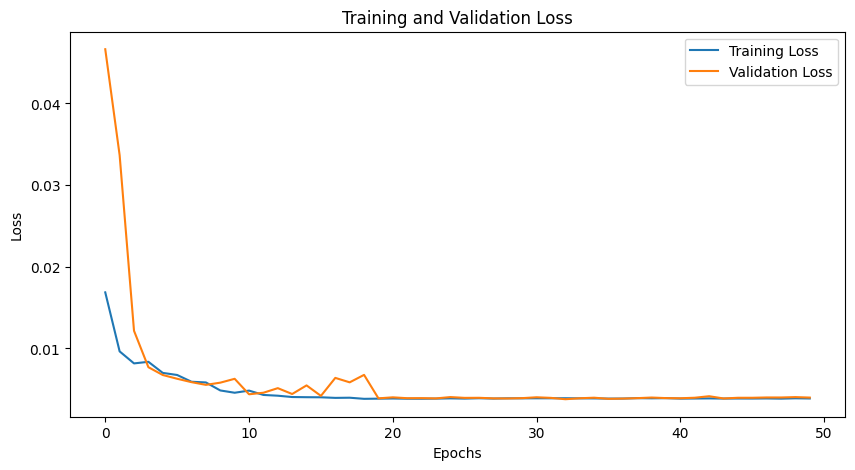

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [47]:
import pickle
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

import re

bs = 256

model = Unet((256,1,1000)).cuda()
path = 'final.pt'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model'])

pick_path = 'output.p'

test = torch.utils.data.DataLoader(BPdatasetv2(0, train = False, val = False,  test = True), batch_size=bs)

temp1 = []
model.eval()
with torch.no_grad():
    for idx,(inputs,labels) in tqdm(enumerate(test),total=len(test),  disable=True):
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs_v= model(inputs).cuda()

        temp1.extend(outputs_v)

temp1 = torch.stack(temp1)
with open(pick_path,'wb') as f:
    pickle.dump(temp1.cpu().detach().numpy(), f)

In [55]:
import pickle
import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def evaluate_BHS_Standard(filename):
    """
        Evaluates PPG2ABP based on
        BHS Standard Metric
    """

    def BHS_metric(err):
        """
        Computes the BHS Standard metric

        Arguments:
            err {array} -- array of absolute error

        Returns:
            tuple -- tuple of percentage of samples with <=5 mmHg, <=10 mmHg and <=15 mmHg error
        """

        leq5 = 0
        leq10 = 0
        leq15 = 0

        for i in range(len(err)):
            if abs(err[i]) <= 5:
                leq5 += 1
                leq10 += 1
                leq15 += 1
            elif abs(err[i]) <= 10:
                leq10 += 1
                leq15 += 1
            elif abs(err[i]) <= 15:
                leq15 += 1

        return (leq5 * 100.0 / len(err), leq10 * 100.0 / len(err), leq15 * 100.0 / len(err))

    def calcError(Ytrue, Ypred, max_abp, min_abp):
        """
        Calculates the absolute error of sbp, dbp, map etc.

        Arguments:
            Ytrue {array} -- ground truth
            Ypred {array} -- predicted
            max_abp {float} -- max value of abp signal
            min_abp {float} -- min value of abp signal

        Returns:
            tuple -- tuple of abs. errors of sbp, dbp and map calculation
        """

        sbps = []
        dbps = []
        maps = []

        for i in range(len(Ytrue)):
            y_t = Ytrue[i].ravel()
            y_p = Ypred[i].ravel()

            y_t = y_t * (max_abp - min_abp)
            y_p = y_p * (max_abp - min_abp)

            dbps.append(abs(min(y_t) - min(y_p)))
            sbps.append(abs(max(y_t) - max(y_p)))
            maps.append(abs(np.mean(y_t) - np.mean(y_p)))

        return (sbps, dbps, maps)

    dt = pickle.load(open(os.path.join('data_mat', 'test.p'), 'rb'))  # loading test data
    Y_test = dt['Y_test']

    max_abp = 178.8
    min_abp = 60.2

    Y_pred = pickle.load(open(filename, 'rb'))  # loading prediction

    (sbps, dbps, maps) = calcError(Y_test, Y_pred, max_abp, min_abp)  # compute errors

    sbp_percent = BHS_metric(sbps)  # compute BHS metric for sbp
    dbp_percent = BHS_metric(dbps)  # compute BHS metric for dbp
    map_percent = BHS_metric(maps)  # compute BHS metric for map

    print('----------------------------')
    print('|        BHS-Metric        |')
    print('----------------------------')

    print('----------------------------------------')
    print('|     | <= 5mmHg | <=10mmHg | <=15mmHg |')
    print('----------------------------------------')
    print('| DBP |  {} %  |  {} %  |  {} %  |'.format(round(dbp_percent[0], 2), round(dbp_percent[1], 2), round(dbp_percent[2], 2)))
    print('| MAP |  {} %  |  {} %  |  {} %  |'.format(round(map_percent[0], 2), round(map_percent[1], 2), round(map_percent[2], 2)))
    print('| SBP |  {} %  |  {} %  |  {} %  |'.format(round(sbp_percent[0], 2), round(sbp_percent[1], 2), round(sbp_percent[2], 2)))
    print('----------------------------------------')


def evaluate_AAMI_Standard(filename):
    """
        Evaluate PPG2ABP using AAMI Standard metric
    """

    def calcErrorAAMI(Ypred, Ytrue, max_abp, min_abp):
        """
        Calculates error of sbp, dbp, map for AAMI standard computation

        Arguments:
            Ytrue {array} -- ground truth
            Ypred {array} -- predicted
            max_abp {float} -- max value of abp signal
            min_abp {float} -- min value of abp signal

        Returns:
            tuple -- tuple of errors of sbp, dbp and map calculation
        """

        sbps = []
        dbps = []
        maps = []

        for i in range(len(Ytrue)):
            y_t = Ytrue[i].ravel()
            y_p = Ypred[i].ravel()

            y_t = y_t * (max_abp - min_abp)
            y_p = y_p * (max_abp - min_abp)

            dbps.append(min(y_p) - min(y_t))
            sbps.append(max(y_p) - max(y_t))
            maps.append(np.mean(y_p) - np.mean(y_t))

        return (sbps, dbps, maps)

    dt = pickle.load(open(os.path.join('data_mat', 'test.p'), 'rb'))  # loading test data
    Y_test = dt['Y_test']

    #dt = pickle.load(open(os.path.join('data', 'meta.p'), 'rb'))  # loading metadata
    max_abp = 178.8
    min_abp = 60.2

    Y_pred = pickle.load(open(filename, 'rb'))  # loading prediction

    (sbps, dbps, maps) = calcErrorAAMI(Y_test, Y_pred, max_abp, min_abp)  # compute error

    print('---------------------')
    print('|   AAMI Standard   |')
    print('---------------------')

    print('-----------------------')
    print('|     |  ME   |  STD  |')
    print('-----------------------')
    print('| DBP | {} | {} |'.format(round(np.mean(dbps), 3), round(np.std(dbps), 3)))
    print('| MAP | {} | {} |'.format(round(np.mean(maps), 3), round(np.std(maps), 3)))
    print('| SBP | {} | {} |'.format(round(np.mean(sbps), 3), round(np.std(sbps), 3)))
    print('-----------------------')


def evaluate_metrics(filename):
    def calcError(Ytrue, Ypred, max_abp, min_abp):
        sbp_t = []
        sbp_p = []
        dbp_t = []
        dbp_p = []
        map_t = []
        map_p = []

        for i in range(len(Ytrue)):
            y_t = Ytrue[i].ravel()
            y_p = Ypred[i].ravel()

            y_t = y_t * (max_abp - min_abp)
            y_p = y_p * (max_abp - min_abp)

            sbp_p.append(abs(max(y_p)))
            dbp_p.append(abs(min(y_p)))
            map_p.append(abs(np.mean(y_p)))
            sbp_t.append(abs(max(y_t)))
            dbp_t.append(abs(min(y_t)))
            map_t.append(abs(np.mean(y_t)))

        print("SBP")
        print("Mean Absolute Error : ", round(mean_absolute_error(sbp_t, sbp_p), 3))
        print("Root Mean Squared Error : ", round(mean_squared_error(sbp_t, sbp_p, squared=False), 3))
        print("R2 : ", r2_score(sbp_t, sbp_p))

        print("")

        print("DBP")
        print("Mean Absolute Error : ", round(mean_absolute_error(dbp_t, dbp_p), 3))
        print("Root Mean Squared Error : ", round(mean_squared_error(dbp_t, dbp_p, squared=False), 3))
        print("R2 : ", r2_score(dbp_t, dbp_p))

        print("")

        print("MAP")
        print("Mean Absolute Error : ", mean_absolute_error(map_t, map_p))
        print("Root Mean Squared Error : ", round(mean_squared_error(map_t, map_p, squared=False), 2))
        print("R2 : ", r2_score(map_t, map_p))

        print("------------------------------------------------------------------------")

    dt = pickle.load(open(os.path.join('data_mat', 'test.p'), 'rb'))  # loading test data
    Y_test = dt['Y_test']

    #dt = pickle.load(open('meta.p', 'rb'))  # loading meta data
    max_abp = 178.8
    min_abp = 60.2

    Y_pred = pickle.load(open(filename, 'rb'))  # loading prediction
    calcError(Y_test, Y_pred, max_abp, min_abp)



In [57]:
evaluate_BHS_Standard('output.p')

----------------------------
|        BHS-Metric        |
----------------------------
----------------------------------------
|     | <= 5mmHg | <=10mmHg | <=15mmHg |
----------------------------------------
| DBP |  40.9 %  |  61.11 %  |  74.21 %  |
| MAP |  41.1 %  |  66.51 %  |  81.29 %  |
| SBP |  26.68 %  |  50.97 %  |  67.89 %  |
----------------------------------------


In [59]:
evaluate_AAMI_Standard('output.p')

---------------------
|   AAMI Standard   |
---------------------
-----------------------
|     |  ME   |  STD  |
-----------------------
| DBP | 9.533 | 8.036 |
| MAP | 0.859 | 10.622 |
| SBP | 1.81 | 15.067 |
-----------------------


In [61]:
evaluate_metrics('output.p')

SBP
Mean Absolute Error :  12.01
Root Mean Squared Error :  15.175
R2 :  -0.06913346685646515

DBP
Mean Absolute Error :  9.395
Root Mean Squared Error :  12.38
R2 :  -1.3636915631277624

MAP
Mean Absolute Error :  8.333696816514301
Root Mean Squared Error :  10.66
R2 :  0.1480613442920985
------------------------------------------------------------------------
